# Laporan Proyek Machine Learning - Robert Varian

# Data Understanding
Dataset yang digunakan adalah Telco Customer Churn Dataset, tersedia di Kaggle:
🔗 https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Dataset ini berisi informasi pelanggan dari perusahaan telekomunikasi fiktif.

## Variabel Utama:
* gender, SeniorCitizen, Partner, Dependents
* tenure, PhoneService, MultipleLines, InternetService
* Contract, PaymentMethod, MonthlyCharges, TotalCharges
* Target: Churn (Yes/No)


# Data Preparation

Melakukan import library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## Data Loading

Memasukkan kaggle.json untuk menggunakan api json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grandhavoc","key":"53aad8c892f982db09c5547e125582c7"}'}

memasukkan kaggle.json agar bisa digunakan

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mendownload library kaggle

In [ ]:
!pip install kaggle

mendownload dataset telco-customer-churn langsung dari kaggle

In [ ]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


membuka file zip yang telah di downloadkan

In [ ]:
import zipfile
with zipfile.ZipFile("telco-customer-churn.zip", "r") as zip_ref:
    zip_ref.extractall("telco_data")

membuka file csv yang telah di download

In [ ]:
df = pd.read_csv("telco_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Melihat apakah pengguna akan churn atau tidak berdasarkan distribusinya

## Exploratory Data Analysis

Menampilkan distribusi fitur beserta churn

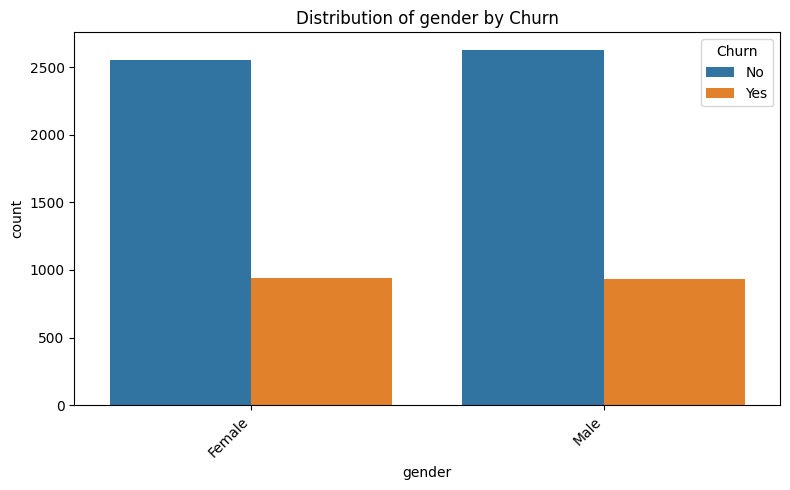

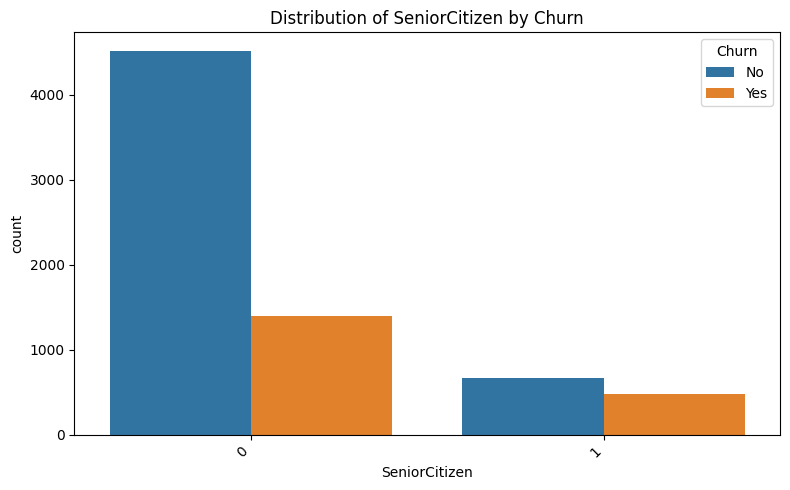

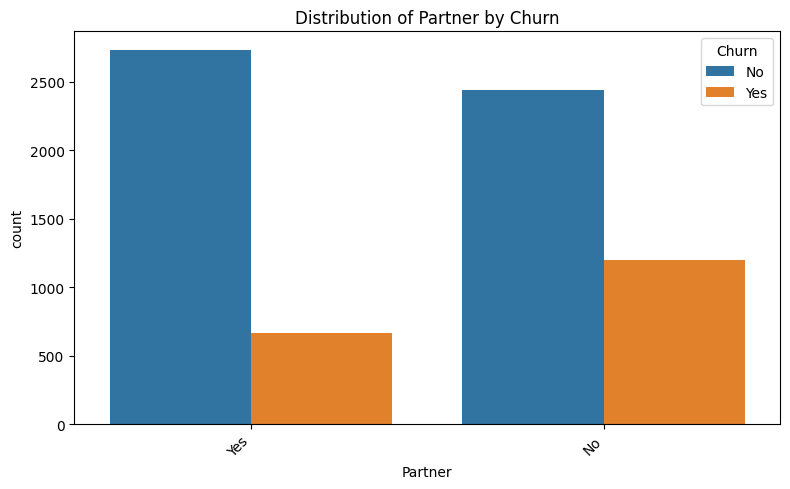

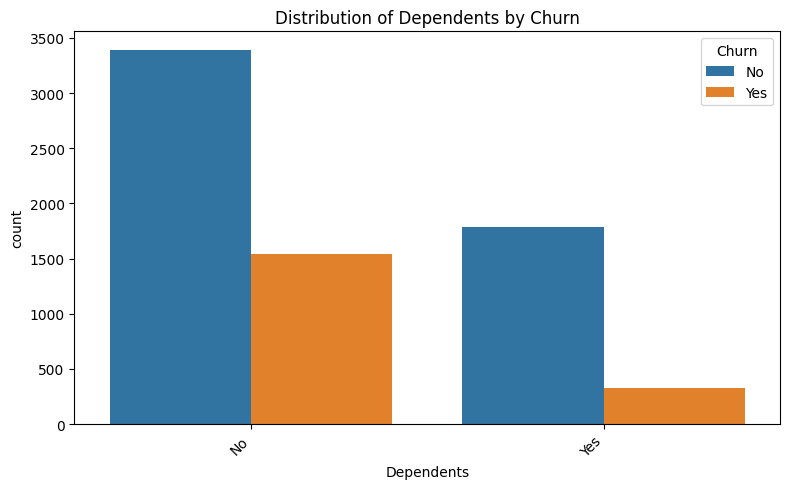

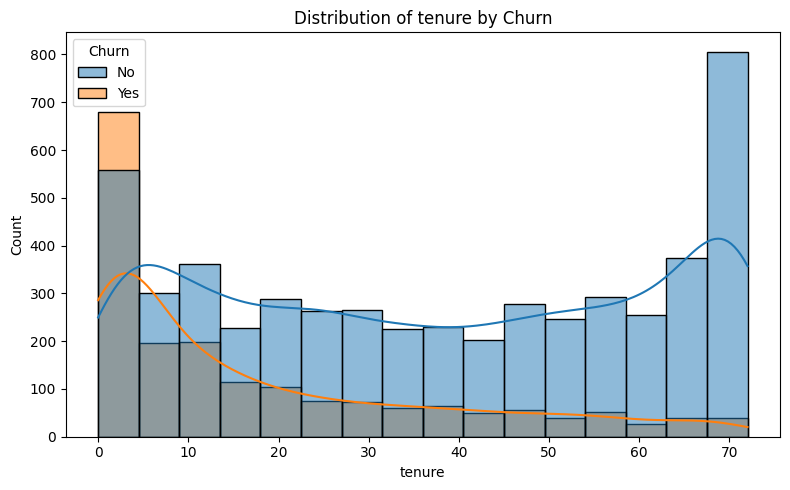

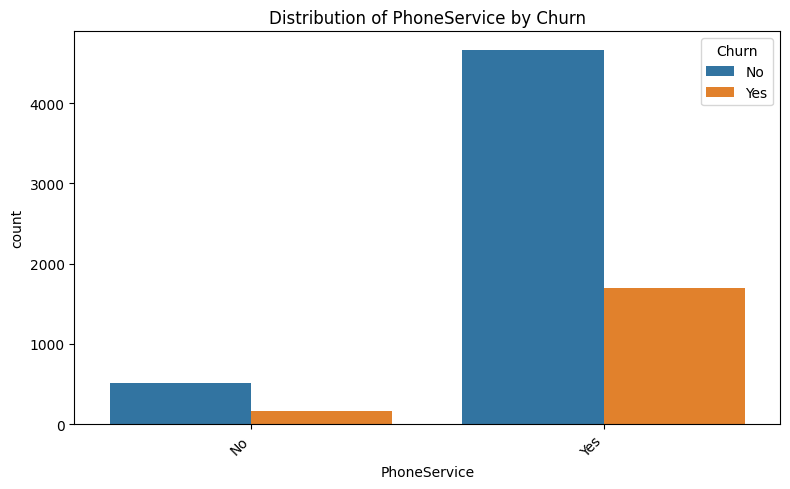

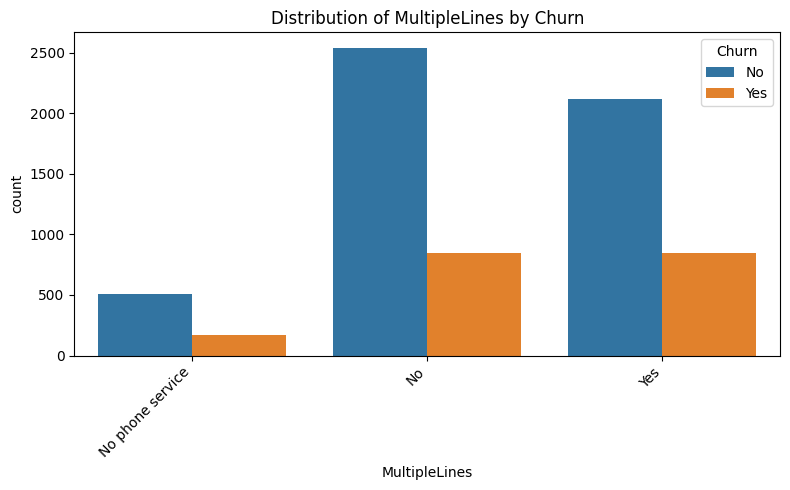

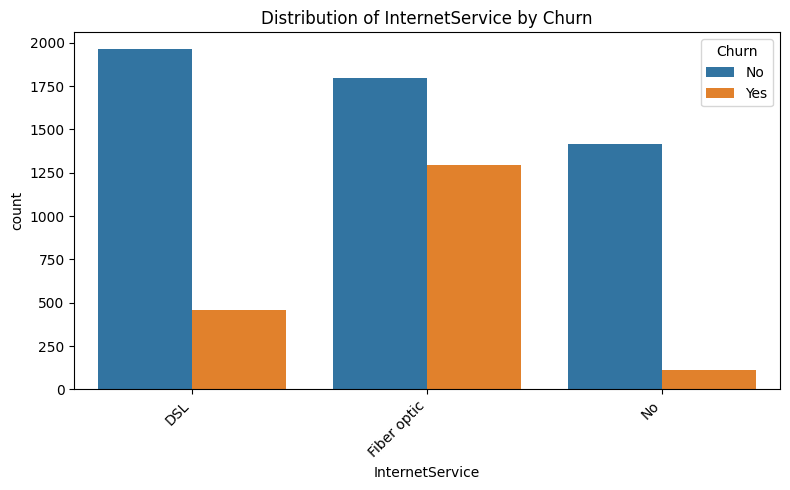

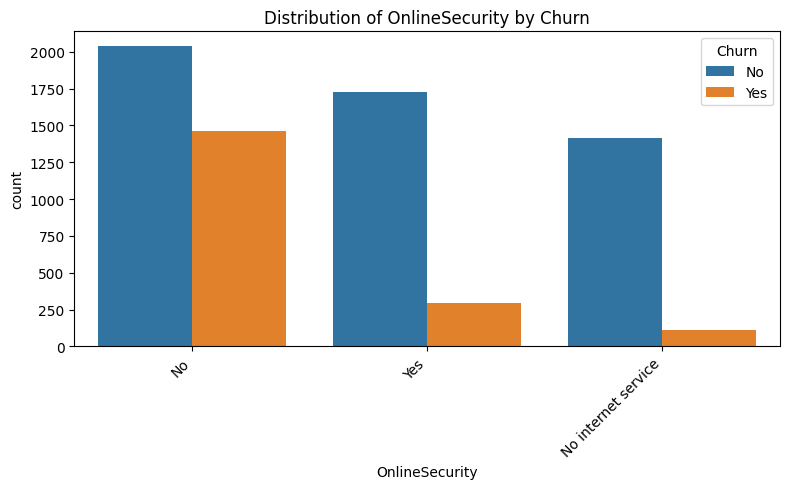

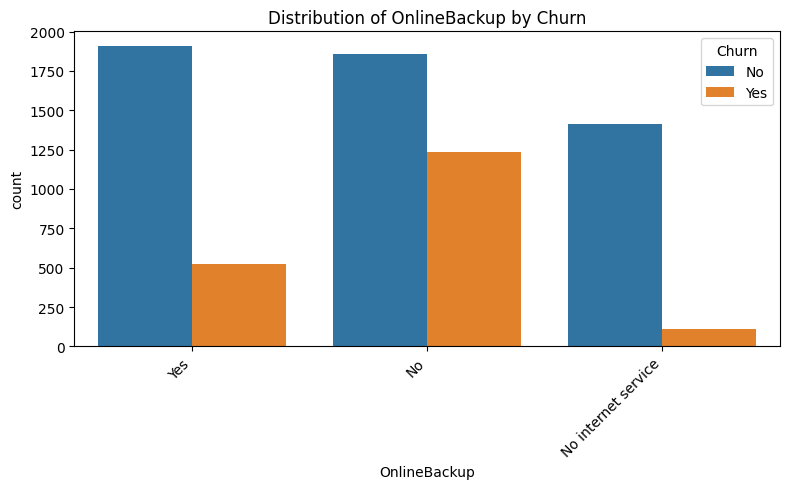

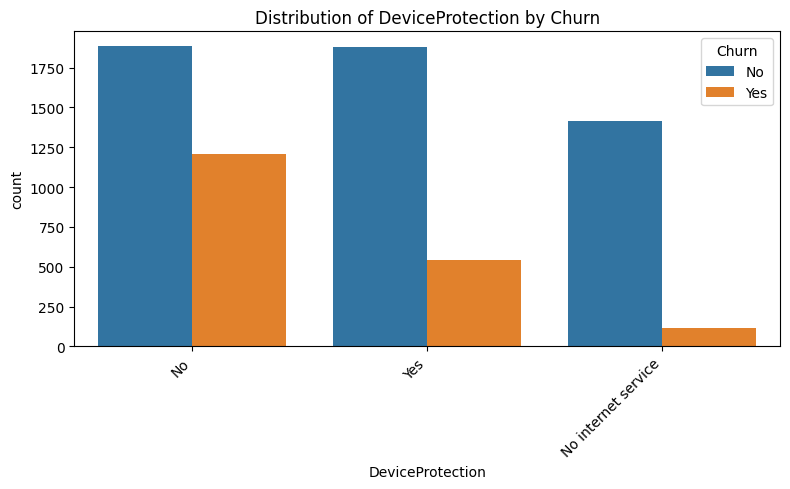

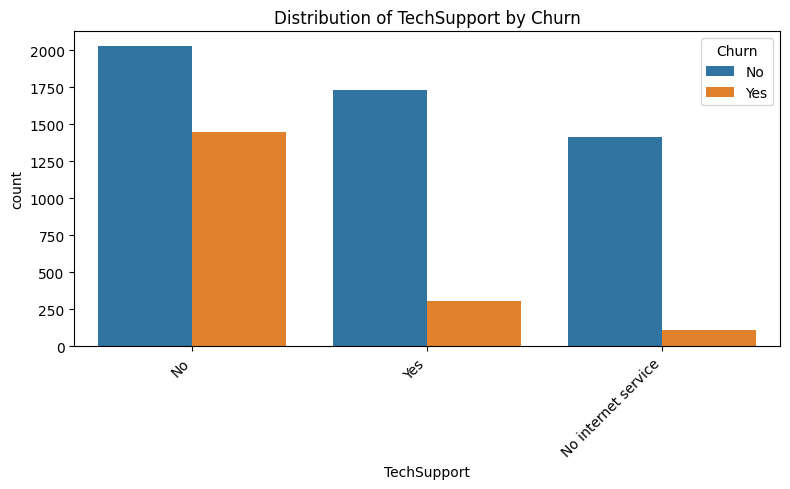

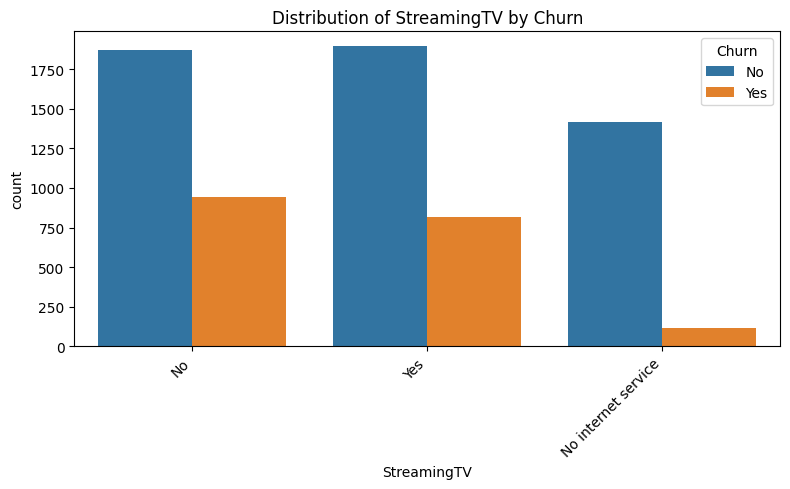

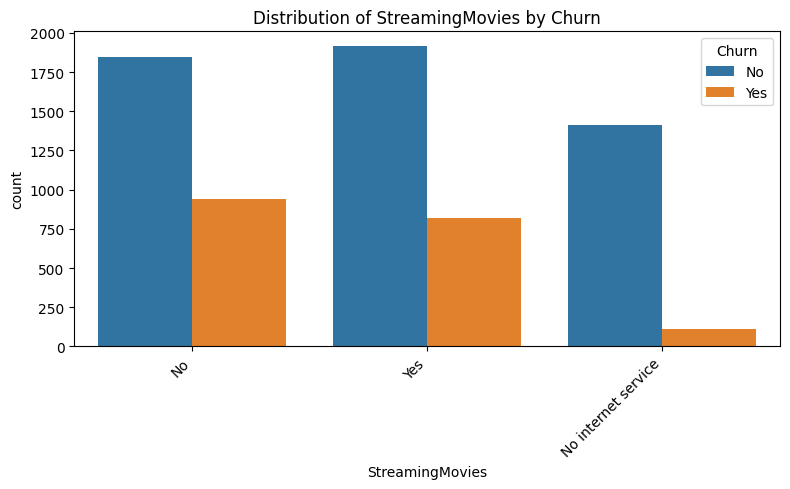

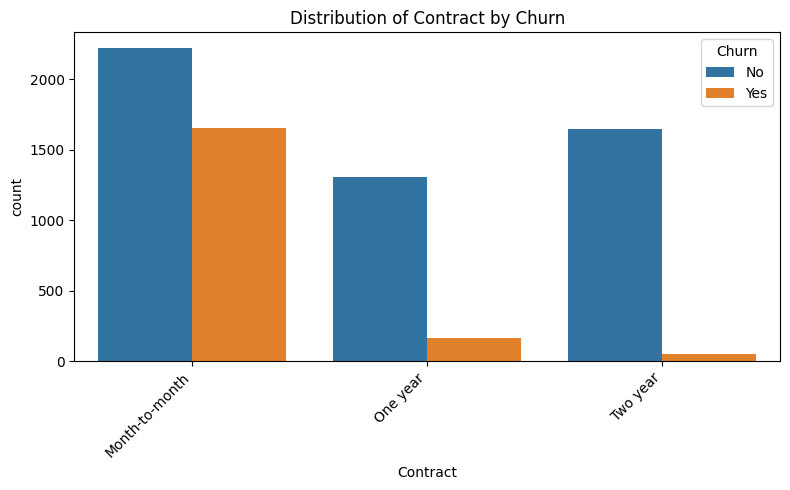

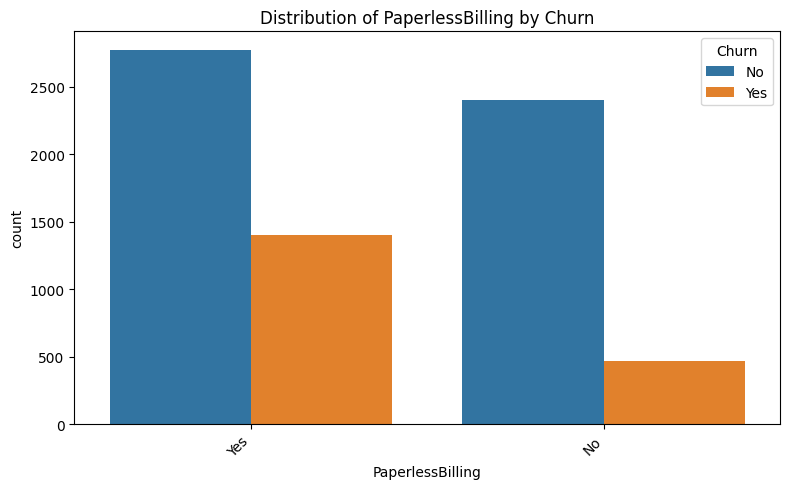

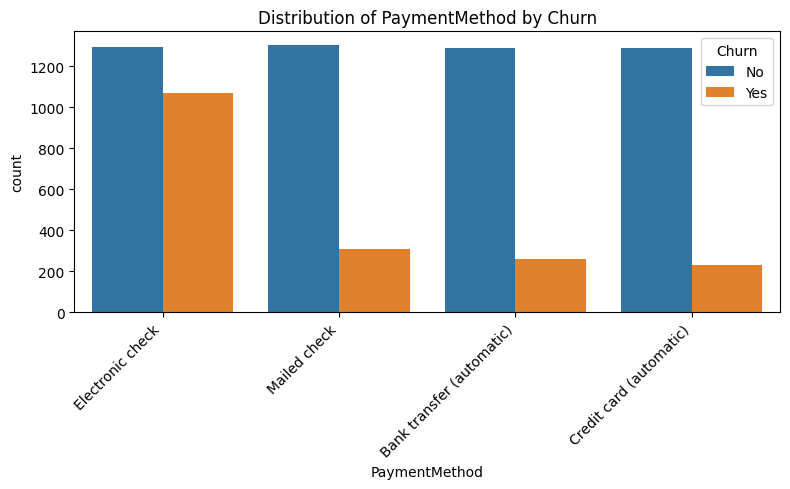

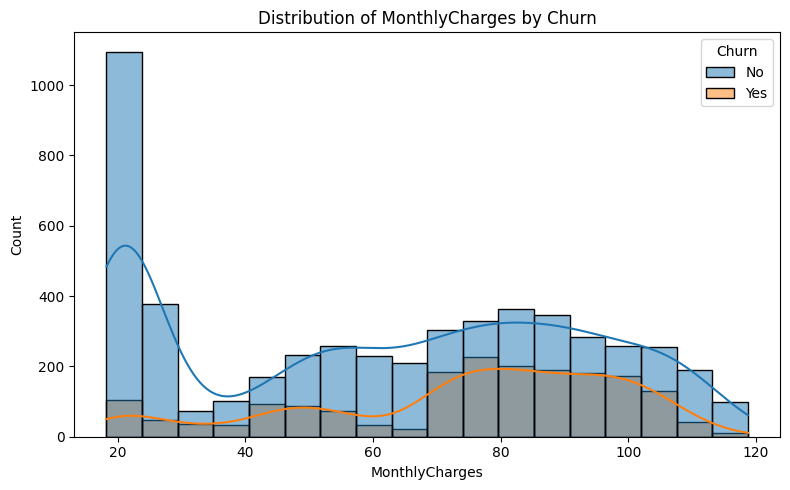

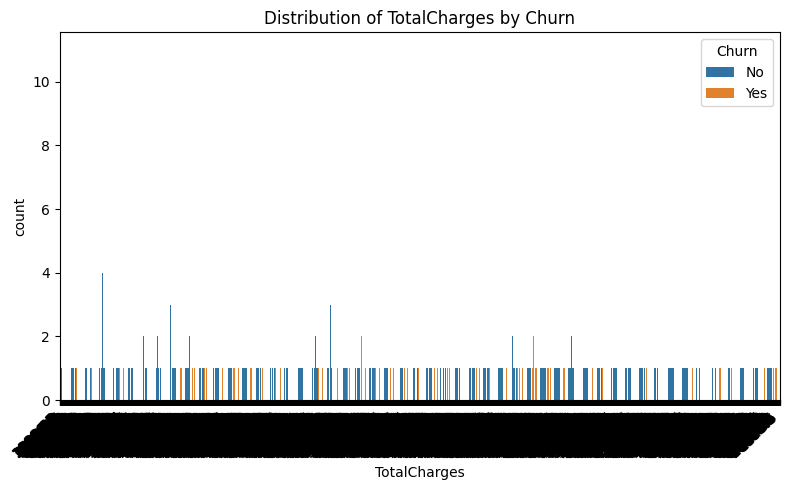

In [ ]:
columns_to_plot = df.columns.tolist()
columns_to_plot.remove('customerID')
columns_to_plot.remove('Churn')

for col in columns_to_plot:
    plt.figure(figsize=(8, 5))
    if df[col].dtype == 'object' or df[col].nunique() < 10: # Categorical or low cardinality columns
        sns.countplot(data=df, x=col, hue='Churn')
        plt.title(f'Distribution of {col} by Churn')
        plt.xticks(rotation=45, ha='right')
    else: # Numerical columns
        sns.histplot(data=df, x=col, hue='Churn', kde=True)
        plt.title(f'Distribution of {col} by Churn')
    plt.tight_layout()
    plt.show()


Berdasarkan plot yang didapatkan diatas didapatkan kesimpulan bahwa churn dapat terjadi kapan saja tidak tergantung dari `monthly charges` atau `total charges`

melakukan deteksi outlier dan menampilkannya pada kolom `total charges` dengan `monthly charges`

Outliers detected in column 'MonthlyCharges' using IQR:
Empty DataFrame
Columns: [MonthlyCharges]
Index: []


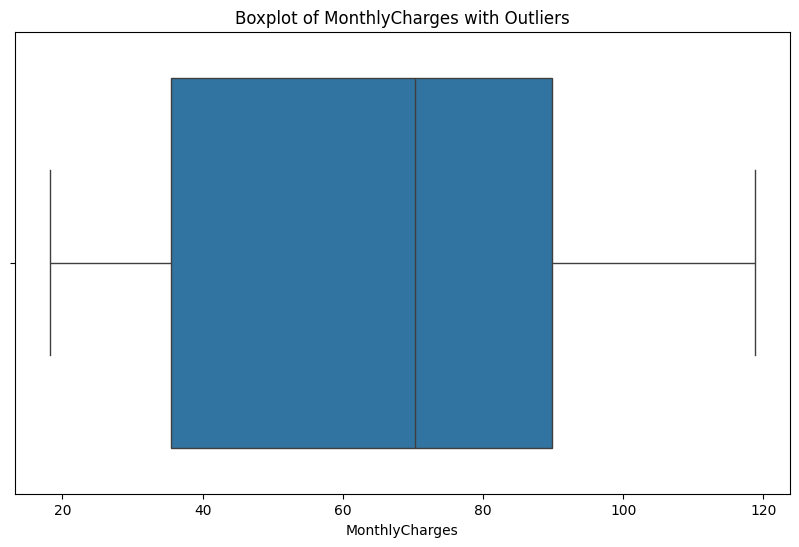

Outliers detected in column 'TotalCharges' using IQR:
Empty DataFrame
Columns: [TotalCharges]
Index: []


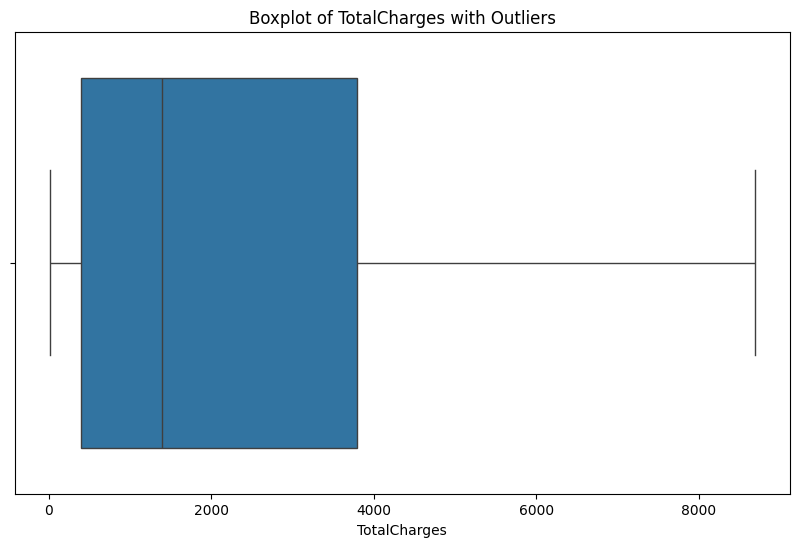

In [ ]:
def detect_and_visualize_outliers_iqr(df, column):
    """
    Detects outliers in a numerical column using the IQR method and visualizes the distribution.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the numerical column to analyze.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Outliers detected in column '{column}' using IQR:")
    print(outliers[[column]])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column} with Outliers')
    plt.xlabel(column)
    plt.show()

detect_and_visualize_outliers_iqr(df.copy(), 'MonthlyCharges')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
detect_and_visualize_outliers_iqr(df.copy(), 'TotalCharges')

Tidak ditemukan outlier pada kedua fitur tersebut

## Data Cleaning

Membersihkan data `total charges`. membuang data kosong, melakukan encode pada `churn`, menghapus `customerid`

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df.drop(['customerID'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)

## Feature Scalling

Melakukan scalling pada data dengan size test 20%

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeling

## Model 1: Logistic Regression

Logistic Regression digunakan untuk klasifikasi biner, dan menghitung probabilitas suatu data termasuk ke dalam kelas positif (misalnya 1).

Rumus matematis:

𝑃
(
𝑦
=
1
∣
𝑋
)
=
1
1
+
𝑒
−
(
𝛽
0
+
𝛽
1
𝑥
1
+
𝛽
2
𝑥
2
+
⋯
+
𝛽
𝑛
𝑥
𝑛
)
P(y=1∣X)=
1+e
−(β
0
​
 +β
1
​
 x
1
​
 +β
2
​
 x
2
​
 +⋯+β
n
​
 x
n
​
 )

1
​

𝑋
=
(
𝑥
1
,
𝑥
2
,
.
.
.
,
𝑥
𝑛
)
X=(x
1
​
 ,x
2
​
 ,...,x
n
​
 ): fitur input

𝛽
=
(
𝛽
0
,
𝛽
1
,
.
.
.
,
𝛽
𝑛
)
β=(β
0
​
 ,β
1
​
 ,...,β
n
​
 ): koefisien model

Fungsi aktivasi yang digunakan adalah sigmoid:

𝜎
(
𝑧
)
=
1
1
+
𝑒
−
𝑧
σ(z)=
1+e
−z

1
​

Prediksi kelas:

𝑦
^
=
{
1
jika
𝑃
(
𝑦
=
1
∣
𝑋
)
>
0.5
0
jika
𝑃
(
𝑦
=
1
∣
𝑋
)
≤
0.5
y
^
​
 ={
1
0
​
  
jika P(y=1∣X)>0.5
jika P(y=1∣X)≤0.5
​



In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

## Model 2: Random Forest

Random Forest adalah ensemble dari banyak decision tree, dan hasil prediksi ditentukan melalui voting (klasifikasi) atau rata-rata (regresi).

Prediksi klasifikasi:

𝑦
^
=
mode
(
𝑇
1
(
𝑋
)
,
𝑇
2
(
𝑋
)
,
.
.
.
,
𝑇
𝑘
(
𝑋
)
)
y
^
​
 =mode(T
1
​
 (X),T
2
​
 (X),...,T
k
​
 (X))
𝑇
𝑖
(
𝑋
)
* T
i
​
 (X): prediksi dari decision tree ke-
𝑖
i

* Hasil akhir adalah mayoritas voting dari semua pohon.

Karakteristik:

* Menggunakan bagging (bootstrap aggregation)

* Mengurangi overfitting dibanding single decision tree

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Model 3: XGBoost

XGBoost membangun model secara bertahap menggunakan boosting, menambahkan pohon baru untuk memperbaiki kesalahan pohon sebelumnya.

Rumus umum (untuk regresi):

𝑦
^
𝑖
(
𝑡
)
=
𝑦
^
𝑖
(
𝑡
−
1
)
+
𝜂
⋅
𝑓
𝑡
(
𝑥
𝑖
)
y
^
​
  
i
(t)
​
 =
y
^
​
  
i
(t−1)
​
 +η⋅f
t
​
 (x
i
​
 )
𝑦
^
𝑖
(
𝑡
)
y
^
​
  
i
(t)
​
 : prediksi pada iterasi ke-
𝑡
t

𝑓
𝑡
f
t
​
 : pohon ke-
𝑡
t

𝜂
η: learning rate

Objektif:

Obj
=
∑
𝑖
=
1
𝑛
𝑙
(
𝑦
𝑖
,
𝑦
^
𝑖
)
+
∑
𝑡
=
1
𝑇
Ω
(
𝑓
𝑡
)
Obj=
i=1
∑
n
​
 l(y
i
​
 ,
y
^
​
  
i
​
 )+
t=1
∑
T
​
 Ω(f
t
​
 )
𝑙
l: loss function (misalnya MSE, log loss)

Ω
(
𝑓
𝑡
)
Ω(f
t
​
 ): regularisasi untuk mengontrol kompleksitas pohon:

Ω
(
𝑓
)
=
𝛾
𝑇
+
1
2
𝜆
∑
𝑗
=
1
𝑇
𝑤
𝑗
2
Ω(f)=γT+
2
1
​
 λ
j=1
∑
T
​
 w
j
2
​



In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Evaluation


Melakukan evaluasi data dari hasil yang didapatkan

In [ ]:
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

results = [
    evaluate_model("Logistic Regression", y_test, y_pred_lr),
    evaluate_model("Random Forest", y_test, y_pred_rf),
    evaluate_model("XGBoost", y_test, y_pred_xgb)
]

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.787491,0.620579,0.516043,0.563504
1,Random Forest,0.785359,0.626761,0.475936,0.541033
2,XGBoost,0.763326,0.565916,0.470588,0.513869


Berdasarkan evaluasi metrik, dibuatkan visualisasi sebagai perbandingan antar model

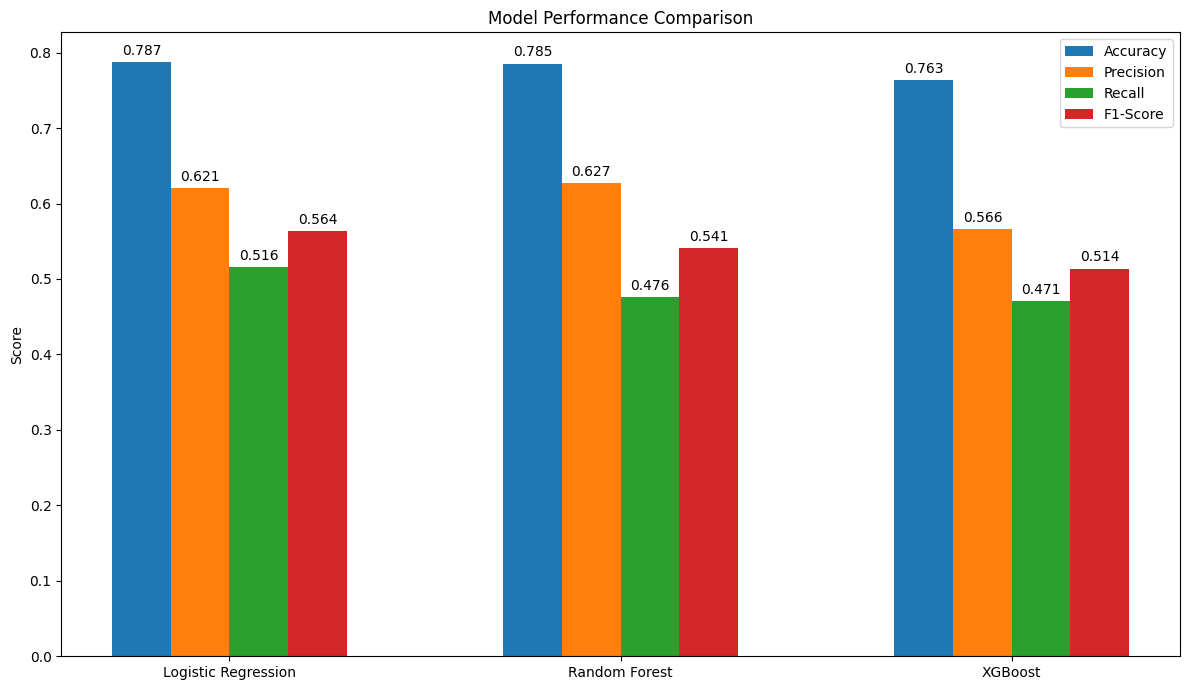

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models = results_df['Model']

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

for i, metric in enumerate(metrics):
    rects = ax.bar(x + i*width, results_df[metric], width, label=metric)
    ax.bar_label(rects, padding=3, fmt='%.3f')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()

Telihat pada gambar diatas bahwa
## Logistic Regression
- Accuracy : 0.787
- Precision : 0.621
- Recall : 0.516
- F1-Score : 0.564

## Random Forest
- Accuracy : 0.785
- Precision : 0.627
- Recall : 0.476
- F1-Score : 0.541

## XGBoost
- Accuracy : 0.763
- Precision : 0.566
- Recall : 0.471
- F1-Score : 0.514

Logistic regression lebih cocok untuk kasus ini. Karena F1-Score yang didapatkan lebih tinggi dibandingkan model Random Forest dan XGBoost.